# Does being a plus member increase customer lifetime value? (Causal Inference)

**Author:** Ekin Derdiyok<br>
**Email:** ekin.derdiyok@icloud.com<br>
**GitHub:** https://github.com/ekinderdiyok<br>
**Date:** 2024-07-23 (start)<br>

## Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import dowhy
import warnings
from dowhy import CausalModel

# Suppress the specific FutureWarning
warnings.filterwarnings('ignore', category=FutureWarning)

print("All packages imported successfully!")

All packages imported successfully!


## Generate synthethic data

In [12]:
# Set random seed for reproducibility
np.random.seed(42)

# Number of samples
N = 1000

# Generate synthetic features
income = np.random.normal(50000, 5000, N)  # Annual income

# Calculate the probability of being a plus member using a logistic function
probability = 1 / (1 + np.exp(-(income - 50000) / 3000))

# Generate binary feature for plus_member
plus_member = np.random.binomial(1, probability)

# Generate customer lifetime value (CLV) with some noise
clv = 0.08 * income + 500 * plus_member + np.random.normal(0, 2000, N)

# Generate an instrumental variable (promo) for the analysis
promo = np.random.binomial(1, 0.5, N)  # 50% chance of receiving a promotion

# Create a DataFrame
data = pd.DataFrame({
    'income': income,
    'plus_member': plus_member,
    'clv': clv,
    'promo': promo
})

# Display the first few rows of the DataFrame
data.head()

,income,plus_member,clv,promo
0,52483.570765,1,4080.267507,0
1,49308.678494,0,2440.381468,0
2,53238.442691,1,5397.424436,1
3,57615.149282,1,7790.112835,0
4,48829.233126,0,155.993711,0


## Plot logistic function and empirical distribution
$$P(\text{plus\_member} \mid \text{income} = x) =  \frac{1}{1 + e^{-\frac{x - 50000}{3000}}}$$

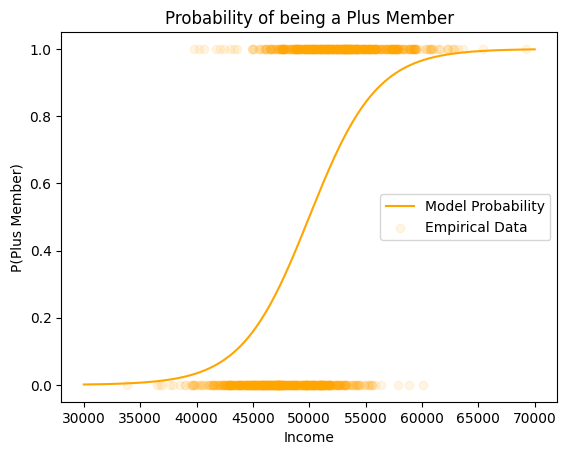

In [21]:
# Plot income and plus_member probability
x = np.linspace(30000, 70000, 1000)
y = 1 / (1 + np.exp(-(x - 50000) / 3000))


plt.plot(x, y, label='Model Probability', color='orange')
plt.scatter(data['income'], data['plus_member'], alpha=0.1, label='Empirical Data', color='orange')
plt.xlabel('Income')
plt.ylabel('P(Plus Member)')
plt.title('Probability of being a Plus Member')
plt.legend()
plt.show()

## Plot income distribution of plus vs non-plus members

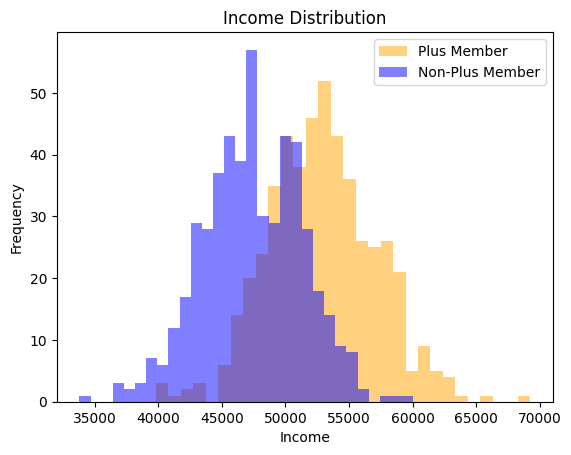

In [22]:
# Plot income distribution for plus_member and non-plus_member
plt.hist(data[data['plus_member'] == 1]['income'], bins=30, alpha=0.5, label='Plus Member', color='orange')
plt.hist(data[data['plus_member'] == 0]['income'], bins=30, alpha=0.5, label='Non-Plus Member', color='blue')
plt.xlabel('Income')
plt.ylabel('Frequency')
plt.title('Income Distribution')
plt.legend()
plt.show()

## Create a causal graph and a model
The graph represents the relationships where `promo` (promotions) and `income` both influence whether someone becomes a `plus_member` (a premium membership status). Both `income` and `plus_member` in turn affect `clv` (customer lifetime value). I set `plus_member` as the treatment and `clv` as the outcome.

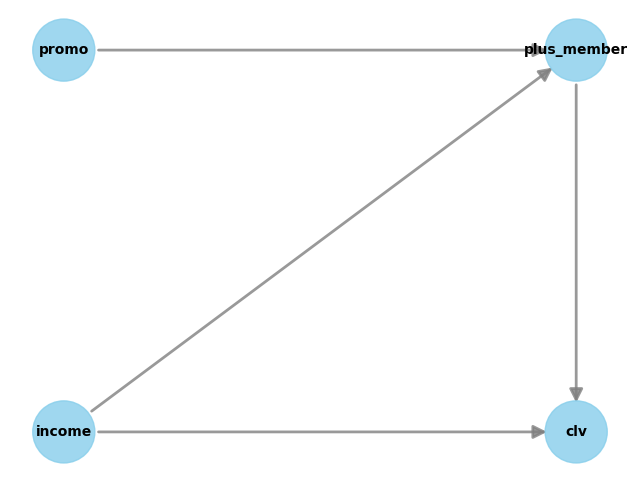

In [23]:
# Create the causal graph
graph = """
digraph {
    promo -> plus_member;
    income -> plus_member;
    income -> clv;
    plus_member -> clv;
}
"""

# Create the causal model using the graph and data. Specify the treatment and outcome variables.
model = CausalModel(
    data=data,
    treatment='plus_member',
    outcome='clv',
    graph=graph
)

# Visualize the causal Directed Acyclic Graph (DAG)
model.view_model()

## Identify the causal effect
- **Backdoor criterion** involves identifying and adjusting for confounding variables that affect both the treatment and the outcome.
- **Frontdoor criterion** involves using an intermediate variable that is influenced by the treatment and affects the outcome, but is not influenced by any confounder affecting both the treatment and the outcome.
- **Instrumental variable** is a variable that influences the treatment but has no direct effect on the outcome except through the treatment.

In [26]:
# Identify the causal effect
identified_estimand = model.identify_effect()

# Print the causal effect
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
      d                      
──────────────(E[clv|income])
d[plus_member]               
Estimand assumption 1, Unconfoundedness: If U→{plus_member} and U→clv then P(clv|plus_member,income,U) = P(clv|plus_member,income)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                                       -1⎤
 ⎢   d          ⎛   d                   ⎞  ⎥
E⎢────────(clv)⋅⎜────────([plus_member])⎟  ⎥
 ⎣d[promo]      ⎝d[promo]               ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→clv then ¬(U →→{promo})
Estimand assumption 2, Exclusion: If we remove {promo}→{plus_member}, then ¬({promo}→clv)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



## Estimate the causal effect using linear regression
The `estimate_effect` function computes the effect of being a plus member on customer lifetime value (CLV), using the `backdoor.linear_regression` method, which means it applies linear regression while considering the backdoor criterion to adjust for confounders. The identified estimand is a theoretical construct that represents the expected causal effect. Here, the estimand type is a Nonparametric Average Treatment Effect (ATE), which is a measure of the average effect of the treatment across the entire population without assuming a specific parametric form for the relationship between variables.

The realized estimand is the practical implementation of this theoretical construct, where the causal effect is estimated using the specified linear regression model. The regression equation `clv ~ plus_member + income` indicates that the outcome (CLV) is modeled as a function of the treatment (plus membership) and the confounder (income).

The estimated effect value quantifies the impact of being a plus member on CLV, while the standard error provides a measure of the precision of this estimate. The confidence intervals offer a range within which the true effect is likely to lie with a certain level of confidence (typically 95%).

In [27]:
# Estimate the causal effect using linear regression
estimate = model.estimate_effect(identified_estimand, method_name="backdoor.linear_regression")
print(estimate)

# Conditional print statements for important aspects of the estimate
def print_estimate_details(estimate):
    estimate_value = estimate.value
    stderr = estimate.get_standard_error()
    ci = estimate.get_confidence_intervals()
    p_value = estimate.test_stat_significance()['p_value']

    # Printing the standard interpretation
    print(f'## Interpretation\nThe estimated effect of being a plus member on customer lifetime value (CLV) is approximately {estimate_value:.2f}')
    
    # Printing the standard error if available
    if stderr is not None:
        stderr_value = float(stderr) if isinstance(stderr, np.ndarray) else stderr
        print(f'Standard Error: {stderr_value:.2f}')
    
    # Printing the confidence intervals if available
    if ci is not None and len(ci) > 0:
        lower_ci, upper_ci = float(ci[0][0]), float(ci[0][1])
        print(f'Confidence Interval: [{lower_ci:.2f}, {upper_ci:.2f}]')
    
    # Printing the p-value if available
    if p_value is not None:
        p_value_value = float(p_value) if isinstance(p_value, np.ndarray) else p_value
        print(f'P-value: {p_value_value:.4f}')
    
    # Extended interpretation based on significance
    if p_value is not None and p_value_value < 0.05:
        print('This result is statistically significant at the 5% level, suggesting that being a plus member has a significant positive effect on CLV.')
    else:
        print('This result is not statistically significant at the 5% level, suggesting that the evidence is not strong enough to conclude a significant effect of being a plus member on CLV.')

# Call the function to print estimate details
print_estimate_details(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
      d                      
──────────────(E[clv|income])
d[plus_member]               
Estimand assumption 1, Unconfoundedness: If U→{plus_member} and U→clv then P(clv|plus_member,income,U) = P(clv|plus_member,income)

## Realized estimand
b: clv~plus_member+income
Target units: ate

## Estimate
Mean value: 569.5524239359356

## Interpretation
The estimated effect of being a plus member on customer lifetime value (CLV) is approximately 569.55
Standard Error: 147.23
Confidence Interval: [280.64, 858.46]
P-value: 0.0001
This result is statistically significant at the 5% level, suggesting that being a plus member has a significant positive effect on CLV.


## Refute the estimate using a placebo test

**Purpose:** The placebo test is a robustness check used in causal inference to verify that the estimated effect of a treatment is not driven by spurious correlations or random chance. The main idea is to test the hypothesis that the observed **treatment effect is due to the actual treatment, and not an artifact** of the data or the model.

**How It Works:** In a placebo test, the treatment is replaced with a fake or placebo treatment, which is known to have no actual effect on the outcome. This fake treatment is typically generated by **shuffling or permuting the treatment assignments**. The model is then re-estimated using this placebo treatment, and the resulting effect is analyzed.

If the original estimated effect was genuine, the effect of the **placebo treatment should be close to zero or statistically insignificant.** If the placebo effect is significant, it suggests that the original effect may be due to random chance or some other confounding factors not accounted for in the model.

In [40]:
# Refute the estimate using a placebo test
refute_placebo = model.refute_estimate(identified_estimand, estimate, method_name="placebo_treatment_refuter")
print(refute_placebo)

# Extracting relevant attributes for conditional interpretation
original_effect = refute_placebo.estimated_effect
new_effect = refute_placebo.new_effect
p_value = refute_placebo.refutation_result['p_value']

# Print conditional explanation based on p-value
if p_value > 0.05:
    print(f'Interpretation: \
          \nThe placebo test indicates that the new effect ({new_effect:.2f}) is not statistically significant (p-value: {p_value:.2f}).  \
          \nThis suggests that the original estimated effect ({original_effect:.2f}) is robust and not likely due to random chance.')
else:
    print(f'Interpretation: \
          \nThe placebo test indicates that the new effect ({new_effect:.2f}) is statistically significant (p-value: {p_value:.2f}). \
          \nThis suggests that the original estimated effect ({original_effect:.2f}) may not be robust and could be due to random chance.')

Refute: Use a Placebo Treatment
Estimated effect:569.5524239359356
New effect:0.9760250572285623
p value:0.98

Interpretation:           
The placebo test indicates that the new effect (0.98) is not statistically significant (p-value: 0.98).            
This suggests that the original estimated effect (569.55) is robust and not likely due to random chance.


## Refute the estimate using a data subset refuter

**Purpose:** The data subset refuter is a robustness check used in causal inference to verify the stability of the estimated treatment effect when the analysis is performed on different subsets of the data. The main idea is to ensure that the estimated causal effect is consistent and **not overly influenced by any particular subset of the data.**

**How It Works:** In a data subset refuter, the original dataset is randomly divided into subsets, and the causal effect is **re-estimated on these subsets.** By comparing the estimated effects from the subsets to the original effect, we can assess the stability and reliability of the original estimate.

If the **estimated effect remains similar across different subsets**, it suggests that the effect is robust and not dependent on any specific part of the data. Conversely, if the effect varies significantly across subsets, it might indicate that the original estimate is sensitive to the data used.

In [48]:
# Refute the estimate using a data subset refuter
refute_subset = model.refute_estimate(identified_estimand, estimate, method_name="data_subset_refuter")
print(refute_subset)

# Extracting relevant attributes for conditional interpretation
original_effect = refute_subset.estimated_effect
new_effect = refute_subset.new_effect
p_value = refute_subset.refutation_result['p_value']

# Print conditional explanation based on p-value
if p_value > 0.05:
    print(f'Interpretation: \
          \nThe data subset refuter indicates that the estimated causal effect ({original_effect:.2f}) is robust to subsampling of the data.\
          \nThe new effect ({new_effect:.2f}) is not significantly different from the estimated causal effect ({original_effect:.2f}), suggesting that the estimated effect is not driven by any specific subset of the data.')
else:
    print(f'Interpretation: The data subset refuter indicates that the estimated causal effect ({original_effect:.2f}) may not be robust to subsampling of the data.\
          \nThe new effect ({new_effect:.2f}) is significantly different, suggesting that the estimated effect might be driven by specific subsets of the data.')

Refute: Use a subset of data
Estimated effect:569.5524239359356
New effect:574.4820991293432
p value:0.8999999999999999

Interpretation:           
The data subset refuter indicates that the estimated causal effect (569.55) is robust to subsampling of the data.          
The new effect (574.48) is not significantly different from the estimated causal effect (569.55), suggesting that the estimated effect is not driven by any specific subset of the data.
